In [1]:
import time
import random
import numpy as np
import torch as th

import jax
import jax.numpy as jnp

from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
from utils.plots import multiviz_trajs

from models.vqvae import VQVAEAgents
from models.sampler.pixelcnn import PixelCNN
from utils.bernstein_coeff_order10_arbitinterval import get_coeffs
from utils.load_data import get_varying_bound_conditions_num_agents
from optimizers.mlp_sf_multi_agent_varying_bounds_1 import InitModel
from optimizers.baseline_with_varying_bounds_2 import multi_agent_qp_node_base
from optimizers.mlp_sf_multi_agent_varying_bounds_1_jax import mlp_sf_multi_agent_jax

In [2]:
manualSeed = 999            
print("Random Seed: ", manualSeed)

random.seed(manualSeed)
th.manual_seed(manualSeed)
np.random.seed(manualSeed)
th.use_deterministic_algorithms(False)

th.set_float32_matmul_precision('high')

Random Seed:  999


In [ ]:
num         = 50
t_fin       = 5
num_agent   = 4

vq_name     = "vary_01"
px_name     = "vary_01"
sf_name     = "vary_01"

batch_size  = 10

nef         = 128   # Size of feature maps in encoder
ndf         = 128   # Size of feature maps in decoder

zdim        = 3     # Size of codebook vectors in the quantizer layer
znum        = 512   # number of codebook vectors

lheight     = 5     # latent vector height
lwidth      = 5     # Latent vector width

num_epochs  = 500
device      = th.device("cuda" if th.cuda.is_available() else "cpu")

maxiter     = 100
epsilon     = 1e-6

print(device)
# th.set_float32_matmul_precision('high')

cuda


In [4]:
P, Pdot, Pddot = get_coeffs(num, t_fin, device)
nvar = P.size(dim=-1) 

dataset = get_varying_bound_conditions_num_agents(num_agent)
test_loader = iter(DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False))

In [5]:
vq_model = VQVAEAgents(
    P, Pdot, Pddot, num_agent=num_agent, nvar=11, emb_num=znum, emb_dim=zdim, zdim=zdim, tdim=3, beta=0.25,
    lheight=lheight, lwidth=lwidth, nef=nef, ndf=ndf, device=device, batch=batch_size
)
vq_model.load_state_dict(th.load(f"./resources/weights/vqvae/{vq_name}_agents_{num_agent}", weights_only=False))
cvq_model = th.compile(vq_model)

vq_model.eval()
vq_model.to(device=device);

In [6]:
sampler = PixelCNN(num_agent, lheight, lwidth, nf=16, n_channels=32, n_layers=3, emb_num=znum, cond_input_shape=96, cond_output_shape=(lheight, lwidth))

sampler.load_state_dict(th.load(f"./resources/weights/sampler/pixel/px_{px_name}_vq_{vq_name}_agents_{num_agent}", weights_only=False))
csampler = th.compile(sampler)

sampler.eval()
sampler.to(device=device);

In [ ]:
pcd_features, hidden_dim_mlp, out_dim_mlp = 6*nvar*num_agent, 2048, (3*nvar*num_agent)+(3*nvar*num_agent)
inp_dim_mlp = pcd_features+(3*nvar*num_agent)+6

if num_agent == 4:
    min_inp, max_inp, inp_mean, inp_std = -2.4249918460845947, 2.4249961376190186, 0.05781755596399307, 0.6251423358917236

model_sf = InitModel(18, 2048, pcd_features, inp_dim_mlp, hidden_dim_mlp, out_dim_mlp, min_inp, max_inp, inp_mean, inp_std, num_agent).to(device)

model_sf.load_state_dict(th.load(f"./resources/weights/filter/sf_{sf_name}_vq_{vq_name}_agents_{num_agent}.pth", weights_only=False))
cmodel_sf = th.compile(model_sf)

model_sf.eval()

multi_agent_learned = mlp_sf_multi_agent_jax(batch_size, num_agent)
multi_agent_learned.maxiter = maxiter
multi_agent_learned.epsilon = epsilon

multi_agent_base = multi_agent_qp_node_base(num_agent, batch_size)
multi_agent_base.maxiter = maxiter

In [8]:
def make_state(x_init, y_init, z_init, x_fin, y_fin, z_fin):

    state_x = th.cat([
        x_init, th.zeros_like(x_init), th.zeros_like(x_init), 
        x_fin, th.zeros_like(x_fin), th.zeros_like(x_fin)
    ], dim=-1)

    state_y = th.cat([
        y_init, th.zeros_like(y_init), th.zeros_like(y_init), 
        y_fin, th.zeros_like(y_fin), th.zeros_like(y_fin)
    ], dim=-1)

    state_z = th.cat([
        z_init, th.zeros_like(z_init), th.zeros_like(z_init), 
        z_fin, th.zeros_like(z_fin), th.zeros_like(z_fin)
    ], dim=-1)

    return state_x, state_y, state_z


def make_inp(x_init, y_init, z_init, x_fin, y_fin, z_fin):
    return th.stack([
        x_init, y_init, z_init, 
        th.zeros_like(x_init), th.zeros_like(y_init), th.zeros_like(z_init), 
        th.zeros_like(x_init), th.zeros_like(y_init), th.zeros_like(z_init), 
        x_fin, y_fin, z_fin, 
        th.zeros_like(x_fin), th.zeros_like(y_fin), th.zeros_like(z_fin), 
        th.zeros_like(x_fin), th.zeros_like(y_fin), th.zeros_like(z_fin), 
    ], dim=-2)

0.04947233200073242
pix sampling done
0.010818243026733398
computation done


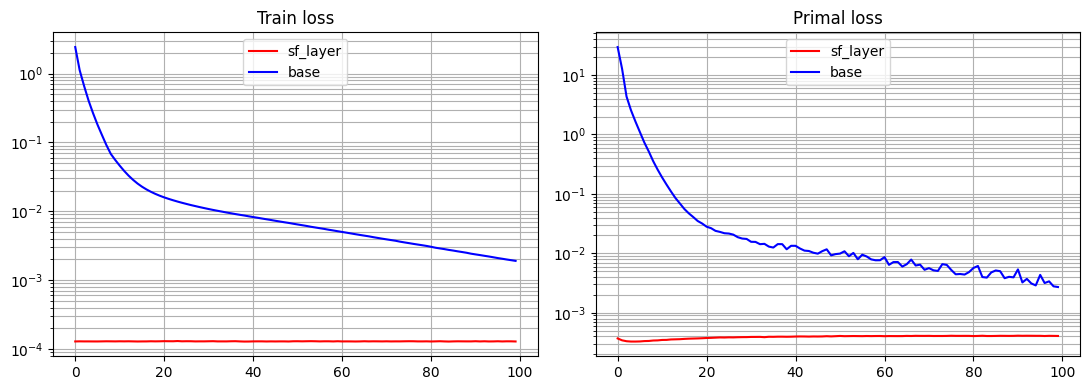

In [10]:
x_init, y_init, z_init, x_fin, y_fin, z_fin, center, radii = next(test_loader)
x_init, y_init, z_init, x_fin, y_fin, z_fin, center, radii = (
	x_init.to(device=device), y_init.to(device=device), z_init.to(device=device), 
	x_fin.to(device=device), y_fin.to(device=device), z_fin.to(device=device),
	center.to(device), radii.to(device) 
)

inits = th.stack([x_init, y_init, z_init], dim=-2)
fins = th.stack([x_fin, y_fin, z_fin], dim=-2)
conditions = th.stack([inits, fins], dim=-1)

state_x, state_y, state_z = make_state(
	x_init, y_init, z_init, x_fin, y_fin, z_fin
)
inp = make_inp(x_init, y_init, z_init, x_fin, y_fin, z_fin)

start = time.time()
with th.no_grad():
	latent_idx = th.zeros(batch_size, num_agent, lheight, lwidth, dtype=th.float32, device=device)
	for i in range(lheight):
		for j in range(lwidth):
			output = sampler(latent_idx, conditions.permute(0, 2, 1, 3))
			latent_idx[:, :, i, j] = th.multinomial(
				th.nn.functional.softmax(output[:, :, i, j].cpu(), dim=-1),
				num_samples=1
			)

	latent = vq_model.quantizer.embedding(latent_idx.to(dtype=th.int32))[:, 0]
	
	print(time.time()-start)
	print('pix sampling done')
	
	c_pred = vq_model.decode(
		latent, 
		x_init.repeat_interleave(batch_size, 0), y_init.repeat_interleave(batch_size, 0), z_init.repeat_interleave(batch_size, 0), 
		x_fin.repeat_interleave(batch_size, 0), y_fin.repeat_interleave(batch_size, 0), z_fin.repeat_interleave(batch_size, 0)
	)
	rec_trajs = (c_pred @ P.mT).cpu().numpy()
	cx_trajs, cy_trajs, cz_trajs = rec_trajs[:, 0, :, :], rec_trajs[:, 1, :, :], rec_trajs[:, 2, :, :]

	cx_pred, cy_pred, cz_pred = (
		c_pred[:, 0, ...].flatten(start_dim=-2), 
		c_pred[:, 1, ...].flatten(start_dim=-2), 
		c_pred[:, 2, ...].flatten(start_dim=-2)
	)
	c_pred_test = th.cat([cx_pred, cy_pred, cz_pred], dim=-1)

	### End - vq-px

	inp_test = th.vstack([inp] * batch_size)
	cen_test = th.vstack([center] * batch_size)
	rad_test = th.vstack([radii] * batch_size)
	state_x_test = th.vstack([state_x]*batch_size)
	state_y_test = th.vstack([state_y]*batch_size)
	state_z_test = th.vstack([state_z]*batch_size)

	c_x_guess, c_y_guess, c_z_guess, lamda_x, lamda_y, lamda_z = model_sf(inp_test, th.cat([c_pred_test, cen_test, rad_test], dim=-1))
	
	c_x_pred = c_pred_test[:, 0 : multi_agent_learned.nvar*multi_agent_learned.num_agent] 
	c_y_pred = c_pred_test[:, multi_agent_learned.nvar*multi_agent_learned.num_agent : 2*multi_agent_learned.nvar*multi_agent_learned.num_agent]  
	c_z_pred = c_pred_test[:, 2*multi_agent_learned.nvar*multi_agent_learned.num_agent : 3*multi_agent_learned.nvar*multi_agent_learned.num_agent]


	x_ell, y_ell, z_ell = center.permute(1, 0)
	x_ell, y_ell, z_ell = (
		x_ell[..., None].cpu() * th.ones((batch_size, num * num_agent)),
		y_ell[..., None].cpu() * th.ones((batch_size, num * num_agent)),
		z_ell[..., None].cpu() * th.ones((batch_size, num * num_agent))
	)

	a_ell, b_ell, c_ell = radii.permute(1, 0)
	a_ell, b_ell, c_ell = (
		a_ell[..., None].cpu() * th.ones((batch_size, num * num_agent)),
		b_ell[..., None].cpu() * th.ones((batch_size, num * num_agent)),
		c_ell[..., None].cpu() * th.ones((batch_size, num * num_agent))
	)
	
	lamda_x_jnp = jnp.asarray( lamda_x.cpu().detach().numpy()  )
	lamda_y_jnp = jnp.asarray( lamda_y.cpu().detach().numpy()  )
	lamda_z_jnp = jnp.asarray( lamda_z.cpu().detach().numpy()  )
	
	c_x_pred_jnp = jnp.asarray( c_x_pred.cpu().detach().numpy()  )
	c_y_pred_jnp = jnp.asarray( c_y_pred.cpu().detach().numpy()  )
	c_z_pred_jnp = jnp.asarray( c_z_pred.cpu().detach().numpy()  )
	
	c_x_guess_jnp = jnp.asarray( c_x_guess.cpu().detach().numpy()  )
	c_y_guess_jnp = jnp.asarray( c_y_guess.cpu().detach().numpy()  )
	c_z_guess_jnp = jnp.asarray( c_z_guess.cpu().detach().numpy()  )

	c_x_guess = th.from_numpy(np.array(c_x_guess_jnp))
	c_y_guess = th.from_numpy(np.array(c_y_guess_jnp))
	c_z_guess = th.from_numpy(np.array(c_z_guess_jnp))
	
		
	state_x_test_jnp = jnp.asarray(state_x_test.cpu().detach().numpy())
	state_y_test_jnp = jnp.asarray(state_y_test.cpu().detach().numpy())
	state_z_test_jnp = jnp.asarray(state_z_test.cpu().detach().numpy())


	start = time.time()
	primal_sol_x, primal_sol_y, primal_sol_z, accumulated_res_primal, accumulated_res_fixed_point, primal_residual, dual_residual = jax.block_until_ready(multi_agent_learned(
		c_x_pred_jnp, c_y_pred_jnp, c_z_pred_jnp, c_x_guess_jnp, c_y_guess_jnp, c_z_guess_jnp, 
		lamda_x_jnp, lamda_y_jnp, lamda_z_jnp, state_x_test_jnp, state_y_test_jnp, state_z_test_jnp, 
		x_ell.cpu().numpy(), y_ell.cpu().numpy(), z_ell.cpu().numpy(), a_ell.cpu().numpy(), b_ell.cpu().numpy(), c_ell.cpu().numpy()
	))
	
	print(time.time()-start)
	print('computation done')

	primal_sol_x_base, primal_sol_y_base, primal_sol_z_base, primal_residual_base, dual_residual_base = multi_agent_base.custom_forward(
		state_x_test_jnp, state_y_test_jnp, state_z_test_jnp, 
		x_ell.cpu().numpy(), y_ell.cpu().numpy(), z_ell.cpu().numpy(), 
		a_ell.cpu().numpy(), b_ell.cpu().numpy(), c_ell.cpu().numpy()
	)
	# primal_sol_x_base, primal_sol_y_base, primal_sol_z_base, _, _, primal_residual_base, dual_residual_base = jax.block_until_ready(multi_agent_learned(
	# 	c_x_pred_jnp, c_y_pred_jnp, c_z_pred_jnp, 
	# 	c_x_pred_jnp, c_y_pred_jnp, c_z_pred_jnp, 
	# 	jnp.zeros_like(lamda_x_jnp), jnp.zeros_like(lamda_y_jnp), jnp.zeros_like(lamda_z_jnp), 
	# 	state_x_test_jnp, state_y_test_jnp, state_z_test_jnp, 
	# 	x_ell.cpu().numpy(), y_ell.cpu().numpy(), z_ell.cpu().numpy(), 
	# 	a_ell.cpu().numpy(), b_ell.cpu().numpy(), c_ell.cpu().numpy()
	# ))

	best_idx = np.nanargmin(primal_residual[-1, :] + 0*dual_residual[-1, :])
	best_idx_base = np.nanargmin(primal_residual_base[-1, :] + 0*dual_residual_base[-1, :])

	primal_sol_x_1 = primal_sol_x[best_idx]
	primal_sol_y_1 = primal_sol_y[best_idx]
	primal_sol_z_1 = primal_sol_z[best_idx]

	primal_sol_x_1 = primal_sol_x_1.reshape(multi_agent_learned.num_agent, multi_agent_learned.nvar)
	primal_sol_y_1 = primal_sol_y_1.reshape(multi_agent_learned.num_agent, multi_agent_learned.nvar)
	primal_sol_z_1 = primal_sol_z_1.reshape(multi_agent_learned.num_agent, multi_agent_learned.nvar)

	primal_sol_x_1_base = primal_sol_x_base[best_idx]
	primal_sol_y_1_base = primal_sol_y_base[best_idx]
	primal_sol_z_1_base = primal_sol_z_base[best_idx]

	primal_sol_x_1_base = primal_sol_x_1_base.reshape(multi_agent_learned.num_agent, multi_agent_learned.nvar)
	primal_sol_y_1_base = primal_sol_y_1_base.reshape(multi_agent_learned.num_agent, multi_agent_learned.nvar)
	primal_sol_z_1_base = primal_sol_z_1_base.reshape(multi_agent_learned.num_agent, multi_agent_learned.nvar)
	
	primal_sol_x_1_init = c_x_pred_jnp[best_idx]
	primal_sol_y_1_init = c_y_pred_jnp[best_idx]
	primal_sol_z_1_init = c_z_pred_jnp[best_idx]

	primal_sol_x_1_init = primal_sol_x_1_init.reshape(multi_agent_learned.num_agent, multi_agent_learned.nvar)
	primal_sol_y_1_init = primal_sol_y_1_init.reshape(multi_agent_learned.num_agent, multi_agent_learned.nvar)
	primal_sol_z_1_init = primal_sol_z_1_init.reshape(multi_agent_learned.num_agent, multi_agent_learned.nvar)

	x_traj = jnp.dot(multi_agent_learned.P, primal_sol_x_1.T).T
	y_traj = jnp.dot(multi_agent_learned.P, primal_sol_y_1.T).T
	z_traj = jnp.dot(multi_agent_learned.P, primal_sol_z_1.T).T

	x_traj_base = jnp.dot(multi_agent_learned.P, primal_sol_x_1_base.T).T
	y_traj_base = jnp.dot(multi_agent_learned.P, primal_sol_y_1_base.T).T
	z_traj_base = jnp.dot(multi_agent_learned.P, primal_sol_z_1_base.T).T
	
	x_traj_init = jnp.dot(multi_agent_learned.P, primal_sol_x_1_init.T).T
	y_traj_init = jnp.dot(multi_agent_learned.P, primal_sol_y_1_init.T).T
	z_traj_init = jnp.dot(multi_agent_learned.P, primal_sol_z_1_init.T).T

	fig = plt.figure(figsize=(11, 4))
	ax = plt.subplot(121)
	ax.plot(primal_residual[:, best_idx], '-r', label="sf_layer")
	ax.plot(primal_residual_base[:, best_idx_base], '-b', label="base")
	ax.set_title("Train loss")
	ax.set_yscale('log')
	ax.grid(which="both")
	ax.legend(loc='upper center')

	ax = plt.subplot(122)
	ax.plot(dual_residual[:, best_idx], '-r', label="sf_layer")
	ax.plot(dual_residual_base[:, best_idx_base], '-b', label="base")
	ax.set_title("Primal loss")
	ax.set_yscale('log')
	ax.grid(which="both")
	ax.legend(loc='upper center')

	plt.tight_layout()
	plt.show()

	vx_trajs, vy_trajs, vz_trajs = np.stack([x_traj_base, cx_trajs[best_idx], x_traj]), np.stack([y_traj_base, cy_trajs[best_idx], y_traj]), np.stack([z_traj_base, cz_trajs[best_idx], z_traj])
	multiviz_trajs(vx_trajs[:3], vy_trajs[:3], vz_trajs[:3], nrows=1, ncols=3, num_agents=num_agent, height=400, width=1_600, titles=["BaseOpt", "Cpred", "SF+vq+opt"])